In [2]:
#necessary imports

from astropy.io import ascii #importing datasets
from astropy import units as u
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D

import time

In [3]:

t0 = time.time()

#number crunching to check if the distances check out. 
data = ascii.read("../Gaia_DR2_messier_37_TRIMMED.csv")

t1 = time.time()

print(t1-t0)

#there are 9000 entries let's hope my computer doesn't die. 
p = data["parallax"]

#this line takes a looonng time to run, like 20 seconds. When I optimize the program I will rewrite the calculations part in Rust.
#parallax = 1 / np.abs(p) * 1000
#print("Finished! Plotting")

fig, ax = plt.subplots()

ax.hist(np.abs(p), bins=100)
ax.set_xlabel("Parallax Angle (milliseconds of arc)")
ax.set_ylabel("frequency")

ax.set_xlim(0,5)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

plt.title("Star Distances from MAST catalog for M37")
plt.show()


#used for calculations. Wish there was a better way because taking inverses is SLOW.
parallax = 1.0 / np.asarray(p) * 1000

0.6312761306762695


UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types dtype('<U18') -> dtype('<U18')

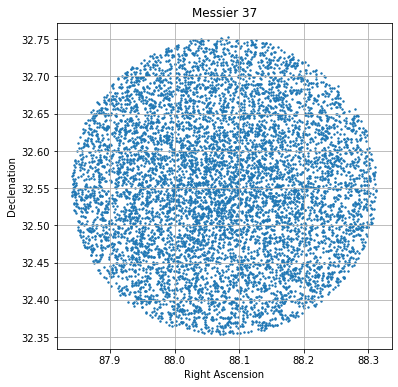

In [3]:

ra = np.asarray(data["ra"])
dec = np.asarray(data["dec"])

star_coords = coord.SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')

plt.figure(figsize=(6, 6))

plt.grid()



plt.title("Messier 37")
plt.xlabel("Right Ascension")
plt.ylabel("Declenation")
plt.scatter(star_coords.ra, star_coords.dec, s=2)

#now we plot!


In [4]:
#spherical to Cartesian conversion

#spherical_to_cart(rtp) [rtt = r theta phi], converts a tuple containing spherical coordinates to a tuple containing x,y,z
#Something really nice about this is all nan radius make the whole coordinate nan so we can ignore it safely.
def spherical_to_cart(rtp):

    xyz=np.zeros_like(rtp) #empty array same size as coords

    index = 0
    for (r,t,p) in rtp[0]:
        #t = np.deg2rad(t)
        #p = np.deg2rad(p)
        if 1300<r<1500:
            x = r * np.cos(t) * np.sin(p)
            y = r * np.sin(t) * np.cos(p)
            z = r * np.cos(p)

            xyz[0][index] = [x,y,z]
        index+=1

    return xyz

coords = np.dstack((parallax, dec, ra)) #converts [p] [dec] [ra] -> (p, dec, ra)
xyz = spherical_to_cart(coords)

#removes all nan
xyz = xyz[~np.isnan(xyz).any(axis=2)]
#removes all 0 rows
xyz = xyz[~(xyz==0).all(1)]

print(xyz)
#saving because it's faster in the long end
np.savetxt("xyz.csv", xyz, delimiter=",")


[[ 214.05518563 1117.19296132 1316.39628642]
 [  64.90260106 1198.25783037 1320.17681657]
 [  63.29155948 1285.79340103 1414.60294096]
 ...
 [ -74.82136656 1232.33855273 1405.89538408]
 [ 173.86538933 1148.63037417 1405.83680143]
 [ 150.43661739 1066.67965568 1311.34351515]]


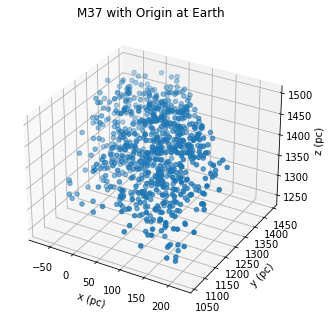

4.6016247272491455


In [5]:
#3d visualiztion
#the library that powers it all
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])

ax.set_title("M37 with Origin at Earth")
ax.set_xlabel("x (pc)")
ax.set_ylabel("y (pc)")
ax.set_zlabel("z (pc)")
plt.show()

